In [1]:
import pandas as pd
import numpy as np

In [81]:
# Point process model processing
file_path = 'KIDPAN_DATA.DAT'
separator = '\t'  
df1 = pd.read_csv(file_path, sep=separator, on_bad_lines='skip', nrows=8000)

rows = list(range(8000))
cols = [199, 176, 201, 280, 262, 270, 197, 191, 26, 295, 25, 417, 393, 392, 10, 294, 171, 301, 315, 123, 307, 308]


selected_data1 = df1.iloc[rows, cols]

column_name = 'Unnamed: 199'

filtered_df4 = selected_data1.dropna(subset=[column_name])

filtered_df4.columns = ['ABO_DON', 'AGE_DON', 'GENDER_DON', 'BMI_DON_CALC', 'HIST_HYPERTENS_DON', 'HIST_DIABETES_DON', 'HEP_C_ANTI_DON', 'HBV_SUR_ANTIGEN_DON', 'ABO', 'AGE', 'GENDER', 'BMI_CALC', 'CMV_STATUS', 'HIV_SEROSTATUS', 'ON_DIALYSIS', 'ABO_MAT', 'HLAMIS', 'COLD_ISCH_KI', 'DAYSWAIT_CHRON_KI', 'TX_DATE', 'GTIME_KI', 'GSTATUS_KI']

filtered_df4.replace('.', pd.NA, inplace=True)

filtered_df4['ABO_DON'] = filtered_df4['ABO_DON'].replace(['A1', 'A2'], 'A')

filtered_df4 = filtered_df4.dropna()

filtered_df4.to_csv('filtered_df4.csv', index=False)

In [69]:
# Data cleaning and preprocessing function
def preprocess_data(data):
    # Convert date column to datetime format
    data['TX_DATE'] = pd.to_datetime(data['TX_DATE'])
    
    # Encode gender
    data['GENDER_DON'] = data['GENDER_DON'].map({'M': 1, 'F': 0})
    data['GENDER'] = data['GENDER'].map({'M': 1, 'F': 0})
    
    # Encode history of hypertension, diabetes, HIV status, etc.
    data['HIST_HYPERTENS_DON'] = data['HIST_HYPERTENS_DON'].map({'Y': 1, 'N': 0})
    data['HIST_DIABETES_DON'] = data['HIST_DIABETES_DON'].map({'Y': 1, 'N': 0})
    data['CMV_STATUS'] = data['CMV_STATUS'].map({'U': 1, 'N': 0})
    data['HIV_SEROSTATUS'] = data['HIV_SEROSTATUS'].map({'U': 1, 'N': 0})
    data['ON_DIALYSIS'] = data['ON_DIALYSIS'].map({1.0: 1, 2.0: 0})
    
    # One-hot encode ABO_DON, HEP_C_ANTI_DON, HBV_SUR_ANTIGEN_DON, ABO
    data = pd.get_dummies(data, columns=['ABO_DON', 'HEP_C_ANTI_DON', 'HBV_SUR_ANTIGEN_DON', 'ABO'], drop_first=True)
    
    # Fill missing values
    data.fillna(0, inplace=True)
    
    # Print column names to check the result of one-hot encoding
    print(data.columns)
    
    # Create covariate matrix X
    X = data[['AGE_DON', 'GENDER_DON', 'BMI_DON_CALC', 'HIST_HYPERTENS_DON', 'HIST_DIABETES_DON', 
              'ABO_DON_B', 'ABO_DON_AB', 'HEP_C_ANTI_DON_P', 'HBV_SUR_ANTIGEN_DON_ND', 
              'AGE', 'GENDER', 'BMI_CALC', 'CMV_STATUS', 'HIV_SEROSTATUS', 'ON_DIALYSIS', 
              'ABO_B', 'ABO_AB', 'ABO_O',
              'ABO_MAT', 'HLAMIS', 'COLD_ISCH_KI', 'DAYSWAIT_CHRON_KI']]
    
    # Response variable y
    y = data['GSTATUS_KI']
    
    return X, y

X, y = preprocess_data(filtered_df4)
print(X.head())
print(y.head())

Index(['AGE_DON', 'GENDER_DON', 'BMI_DON_CALC', 'HIST_HYPERTENS_DON',
       'HIST_DIABETES_DON', 'AGE', 'GENDER', 'BMI_CALC', 'CMV_STATUS',
       'HIV_SEROSTATUS', 'ON_DIALYSIS', 'ABO_MAT', 'HLAMIS', 'COLD_ISCH_KI',
       'DAYSWAIT_CHRON_KI', 'TX_DATE', 'GTIME_KI', 'GSTATUS_KI', 'ABO_DON_AB',
       'ABO_DON_B', 'ABO_DON_O', 'HEP_C_ANTI_DON_ND', 'HEP_C_ANTI_DON_P',
       'HEP_C_ANTI_DON_U', 'HBV_SUR_ANTIGEN_DON_ND', 'HBV_SUR_ANTIGEN_DON_U',
       'ABO_AB', 'ABO_B', 'ABO_O'],
      dtype='object')
   AGE_DON  GENDER_DON BMI_DON_CALC  HIST_HYPERTENS_DON  HIST_DIABETES_DON  \
1       35         0.0   23.5134453                 0.0                0.0   
3       17         0.0   18.1786704                 0.0                0.0   
8       16         0.0   18.9541158                 0.0                0.0   
14      29         0.0   23.0254711                 0.0                0.0   
18      64         0.0   39.4444444                 0.0                0.0   

    ABO_DON_B  ABO_DON_A

In [70]:
X = X.astype(float)
y = y.astype(int)

In [71]:
from scipy.optimize import minimize

def log_partial_likelihood(beta, X, y):
    linear_predictor = np.dot(X, beta)
    risk_set = np.exp(linear_predictor)
    log_likelihood = np.sum(linear_predictor[y == 1]) - np.sum(np.log(np.cumsum(risk_set[::-1])[::-1]))
    return -log_likelihood

# Test log partial likelihood function
beta_init = np.zeros(X.shape[1])
print(log_partial_likelihood(beta_init, X.values, y.values))

9532.935902808715


In [72]:
def train_model(X, y):
    beta_init = np.zeros(X.shape[1])
    result = minimize(log_partial_likelihood, beta_init, args=(X.values, y.values), method='BFGS')
    return result.x

beta = train_model(X, y)
print(beta)

C:\Windows\Temp\ipykernel_8252\2204930289.py:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(linear_predictor[y == 1]) - np.sum(np.log(np.cumsum(risk_set[::-1])[::-1]))
d:\python311\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[ 1.56187007e-02  0.00000000e+00 -3.14820541e-01  0.00000000e+00
  0.00000000e+00 -2.57706769e+00 -5.06031247e+01 -3.72352203e+01
 -7.48356276e-01 -3.25366125e-02  0.00000000e+00 -9.96487135e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.03436120e+00
  5.28649279e+01  3.35729327e+00 -9.36970172e+01 -5.51194279e-01
 -2.87130596e-03 -7.63629119e-04]


C:\Windows\Temp\ipykernel_8252\2204930289.py:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(linear_predictor[y == 1]) - np.sum(np.log(np.cumsum(risk_set[::-1])[::-1]))
d:\python311\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Model AUC: 0.4937989490929433


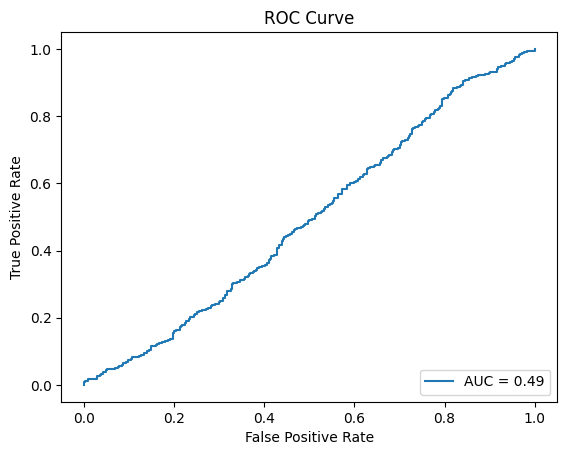

In [73]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(beta, X, y):
    linear_predictor = np.dot(X, beta)
    predictions = 1 / (1 + np.exp(-linear_predictor))
    auc = roc_auc_score(y, predictions)
    fpr, tpr, _ = roc_curve(y, predictions)
    return auc, fpr, tpr

auc, fpr, tpr = evaluate_model(beta, X, y)
print(f'Model AUC: {auc}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [83]:
# Data cleaning and preprocessing function
def preprocess_data(data):
    # Convert date column to datetime format
    data['TX_DATE'] = pd.to_datetime(data['TX_DATE'])
    
    # Encode gender
    data['GENDER_DON'] = data['GENDER_DON'].map({'M': 1, 'F': 0})
    data['GENDER'] = data['GENDER'].map({'M': 1, 'F': 0})
    
    # Encode history of hypertension, diabetes, HIV status, etc.
    data['HIST_HYPERTENS_DON'] = data['HIST_HYPERTENS_DON'].map({'Y': 1, 'N': 0})
    data['HIST_DIABETES_DON'] = data['HIST_DIABETES_DON'].map({'Y': 1, 'N': 0})
    data['CMV_STATUS'] = data['CMV_STATUS'].map({'U': 1, 'N': 0})
    data['HIV_SEROSTATUS'] = data['HIV_SEROSTATUS'].map({'U': 1, 'N': 0})
    data['ON_DIALYSIS'] = data['ON_DIALYSIS'].map({1.0: 1, 2.0: 0})
    
    # One-hot encode ABO_DON, HEP_C_ANTI_DON, HBV_SUR_ANTIGEN_DON, ABO
    data = pd.get_dummies(data, columns=['ABO_DON', 'HEP_C_ANTI_DON', 'HBV_SUR_ANTIGEN_DON', 'ABO'], drop_first=True)
    
    # Fill missing values
    data.fillna(0, inplace=True)
    
    # Print column names to check the result of one-hot encoding
    print(data.columns)
    
    # Create covariate matrix X
    X = data[['AGE_DON', 'GENDER_DON', 'BMI_DON_CALC', 'HIST_HYPERTENS_DON', 'HIST_DIABETES_DON', 
              'ABO_DON_B', 'ABO_DON_AB', 'HEP_C_ANTI_DON_P', 'HBV_SUR_ANTIGEN_DON_ND', 
              'AGE', 'GENDER', 'BMI_CALC', 'CMV_STATUS', 'HIV_SEROSTATUS', 'ON_DIALYSIS', 
              'ABO_B', 'ABO_AB', 'ABO_O',
              'ABO_MAT', 'HLAMIS', 'COLD_ISCH_KI', 'DAYSWAIT_CHRON_KI']]
    
    # Response variable y
    y = data['GSTATUS_KI']
    
    return X, y

X, y = preprocess_data(filtered_df4)

X = X.astype(float)
y = y.astype(int)

print(X.head())
print(y.head())

Index(['AGE_DON', 'GENDER_DON', 'BMI_DON_CALC', 'HIST_HYPERTENS_DON',
       'HIST_DIABETES_DON', 'AGE', 'GENDER', 'BMI_CALC', 'CMV_STATUS',
       'HIV_SEROSTATUS', 'ON_DIALYSIS', 'ABO_MAT', 'HLAMIS', 'COLD_ISCH_KI',
       'DAYSWAIT_CHRON_KI', 'TX_DATE', 'GTIME_KI', 'GSTATUS_KI', 'ABO_DON_AB',
       'ABO_DON_B', 'ABO_DON_O', 'HEP_C_ANTI_DON_ND', 'HEP_C_ANTI_DON_P',
       'HEP_C_ANTI_DON_U', 'HBV_SUR_ANTIGEN_DON_ND', 'HBV_SUR_ANTIGEN_DON_U',
       'ABO_AB', 'ABO_B', 'ABO_O'],
      dtype='object')
    AGE_DON  GENDER_DON  BMI_DON_CALC  HIST_HYPERTENS_DON  HIST_DIABETES_DON  \
1      35.0         0.0     23.513445                 0.0                0.0   
3      17.0         0.0     18.178670                 0.0                0.0   
8      16.0         0.0     18.954116                 0.0                0.0   
14     29.0         0.0     23.025471                 0.0                0.0   
18     64.0         0.0     39.444444                 0.0                0.0   

    ABO_DON_

In [84]:
def initialize_values(X):
    n, p = X.shape
    beta_init = np.zeros(p)
    W0 = np.ones(n)  # Initial value of W0
    gamma = np.ones(n)  # Initial value of gamma
    return beta_init, W0, gamma

beta_init, W0, gamma = initialize_values(X)

In [85]:
def compute_dynamic_part(X):
    # Compute the dynamic part ΔX_t(i, j)
    delta_X = X.diff().fillna(0)
    return delta_X

delta_X = compute_dynamic_part(X)

In [87]:
def compute_gradient_and_hessian(beta, X, y, gamma):
    n, p = X.shape
    exp_X_beta = np.exp(X @ beta)
    W = gamma * exp_X_beta
    sum_W = np.sum(W)
    
    # Compute the probability for each risk set
    P = W / sum_W
    
    # Gradient
    gradient = X.T @ (P - y)
    
    # Hessian matrix
    XT_W = X.T * W
    hessian = XT_W @ X / sum_W - (XT_W @ P) @ (X.T @ P).T / sum_W**2
    
    return gradient, hessian

# Initial values
beta_init = np.zeros(X.shape[1])
gamma = np.ones(len(X))  # May need to adjust based on actual situation

# Compute gradient and Hessian matrix
gradient, hessian = compute_gradient_and_hessian(beta_init, X, y, gamma)

print("Gradient:\n", gradient)
print("Hessian:\n", hessian)

Gradient:
 AGE_DON                   -40517.051724
GENDER_DON                     0.000000
BMI_DON_CALC              -28361.080393
HIST_HYPERTENS_DON             0.000000
HIST_DIABETES_DON              0.000000
ABO_DON_B                   -143.868700
ABO_DON_AB                   -31.974801
HEP_C_ANTI_DON_P             -18.984748
HBV_SUR_ANTIGEN_DON_ND        -0.999337
AGE                       -51351.217507
GENDER                         0.000000
BMI_CALC                  -86389.438793
CMV_STATUS                     0.000000
HIV_SEROSTATUS                 0.000000
ON_DIALYSIS                    0.000000
ABO_B                       -144.866711
ABO_AB                       -41.966180
ABO_O                       -614.476790
ABO_MAT                    -1187.974801
HLAMIS                     -4295.355438
COLD_ISCH_KI              -24189.840782
DAYSWAIT_CHRON_KI        -872279.154509
dtype: float64
Hessian:
                              AGE_DON  GENDER_DON  BMI_DON_CALC  \
AGE_DON           

In [91]:
# Objective function
def objective_function(beta, X, y, gamma):
    _, hessian = compute_gradient_and_hessian(beta, X, y, gamma)
    return 0.5 * beta.T @ hessian @ beta - y @ (X @ beta)

# Optimize using scipy.optimize's minimize function
from scipy.optimize import minimize

result = minimize(lambda beta: objective_function(beta, X, y, gamma), beta_init, method='Newton-CG',
                  jac=lambda beta: compute_gradient_and_hessian(beta, X, y, gamma)[0],
                  hess=lambda beta: compute_gradient_and_hessian(beta, X, y, gamma)[1])
beta_optimal = result.x
print("Optimal beta:", beta_optimal)

Optimal beta: [4.63199092e+01 0.00000000e+00 3.24229581e+01 0.00000000e+00
 0.00000000e+00 1.64473594e-01 3.65542363e-02 2.17037461e-02
 1.14246203e-03 5.87057456e+01 0.00000000e+00 9.87621456e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65614540e-01
 4.79765822e-02 7.02482237e-01 1.35811671e+00 4.91053681e+00
 2.76543130e+01 9.97207090e+02]


Model AUC: 0.5


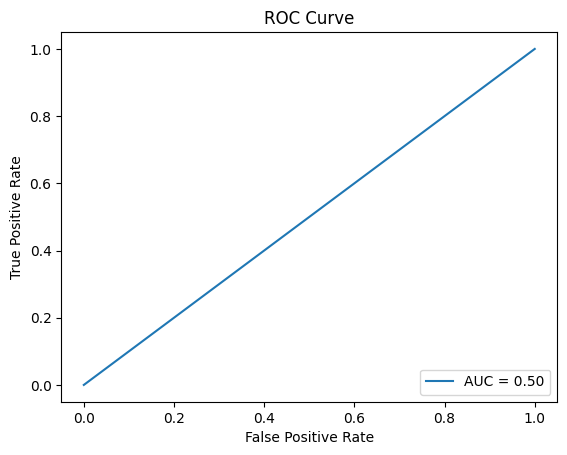

In [92]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def evaluate_model(beta, X, y):
    linear_predictor = np.dot(X, beta)
    predictions = 1 / (1 + np.exp(-linear_predictor))
    auc = roc_auc_score(y, predictions)
    fpr, tpr, _ = roc_curve(y, predictions)
    return auc, fpr, tpr

auc, fpr, tpr = evaluate_model(beta_optimal, X, y)
print(f'Model AUC: {auc}')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()